# Data Preparation, Partion, Trainning and Evaluation
This notebook loads the previously cleaned data, prepares it, partitions it and trains it using logistic regression and Random Forest 
## 1. Data Preparation
In this first step, we'll load and prepare our data following the specification of the project (Yatish et al., 2019)
### 1.1. Feature Selection


In [1]:
%matplotlib inline

from collections import Counter
from ydata_profiling import ProfileReport
import glob
import os
import re
import random
import matplotlib.pyplot as plt
from pathlib import Path as path
import numpy as np
import pandas as pd
import seaborn as sns
#from pandas_profiling import ProfileReport
import ydata_profiling
from imblearn.over_sampling import SMOTE
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    precision_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path

In order to simplify repertory changes, we'll initialize two variables, containning the paths of this current repository and the path of your clone of the Apache Hive repertory.

In [2]:
#les chemins d'accès aux fichiers
root_file="C:/Users/14387"

os.chdir(root_file)
actual_dir=Path.cwd()

project_repo = actual_dir/"Apache_Hive_Bug_Prediction_ML_/"
#hive_repo = project_repo.parent/"Apache_Hive/"
#os.chdir(hive_repo)



#project_repo = path("/home/nicolas-richard/Desktop/.Apache_Hive_Bug_Prediction_ML_Model")

In [3]:
def extract_version(filename):
    file_part = filename.split('/')[-1]

    parts = file_part.split('-')
    if len(parts) < 2:
        raise ValueError("Filename does not contain a version segment.")

    version_part = parts[1].split('_')[0]
    return version_part

In [4]:
input_files = glob.glob(os.path.join(project_repo, 'UND_hive_updated_data_model2', '*.csv'))

concatenated_df = pd.DataFrame()

for file in input_files:
    df = pd.read_csv(file)
    
    version = extract_version(file)
    df.insert(loc=2, column='Version', value=version)
    concatenated_df = pd.concat([concatenated_df, df], ignore_index=True)

concatenated_df.info()
count = concatenated_df['Version'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147744 entries, 0 to 147743
Data columns (total 100 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Bug                                 147744 non-null  int64  
 1   FileName                            147744 non-null  object 
 2   Version                             147744 non-null  object 
 3   AvgCountLine                        147744 non-null  float64
 4   AvgCountLineBlank                   147744 non-null  float64
 5   AvgCountLineCode                    147744 non-null  float64
 6   AvgCountLineComment                 147744 non-null  float64
 7   AvgCyclomatic                       147744 non-null  float64
 8   AvgCyclomaticModified               147744 non-null  float64
 9   AvgCyclomaticStrict                 147744 non-null  float64
 10  AvgCyclomaticStrictModified         147744 non-null  float64
 11  AvgEssential             

Below, we'll just reorder our dataframe by column

In [5]:
concatenated_df.drop_duplicates
data = concatenated_df.iloc[:,[0,7,8,9,11,3,4,5,6,20,21,22,27,28,29,33,36,38,39,
                               40,42,43,44,45,46,47,53,54,55,57,64,65,66,75,76,
                               77,78,80,16,17,19,70,73,82,83,84,85,86,87,88,89,
                               90,91,92,93]]
data.dropna(inplace=True)
data = data.reset_index(drop=True)
data.info()

X = data.drop('Bug', axis=1)
y = data['Bug']

print("Class Distribution:")
print(y.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147340 entries, 0 to 147339
Data columns (total 55 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Bug                        147340 non-null  int64  
 1   AvgCyclomatic              147340 non-null  float64
 2   AvgCyclomaticModified      147340 non-null  float64
 3   AvgCyclomaticStrict        147340 non-null  float64
 4   AvgEssential               147340 non-null  float64
 5   AvgCountLine               147340 non-null  float64
 6   AvgCountLineBlank          147340 non-null  float64
 7   AvgCountLineCode           147340 non-null  float64
 8   AvgCountLineComment        147340 non-null  float64
 9   CountDeclClass             147340 non-null  float64
 10  CountDeclClassMethod       147340 non-null  float64
 11  CountDeclClassVariable     147340 non-null  float64
 12  CountDeclFunction          147340 non-null  float64
 13  CountDeclInstanceMethod    14

C:\Users\14387\AppData\Local\Temp\ipykernel_24172\2438580515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


We now have 55 columns. This includes all the *46 independent variables* at study (37 related to files, 5 related to classes and 4 related to methods (expanded to 12 for simplicity's sake) mentionned in *Yatish et al., 2019*) in addition to the first column, specify whether there is a bug in a given file. The dataframe is structured as follows

### 1.2. Data Exploration

In [6]:
profile = ProfileReport(data, 
                        title='Apache Hive Bug Dataset Profile Report',
                        pool_size=4,
                        html={'style': {'full_width': True}},
                        minimal=True)
profile.to_notebook_iframe()
data.to_csv("Data_Preparation_Output2.csv",index=False)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 1.3.Outlier Detection and Handling
Before we split our dataframe, we'll get rid of the outliers within our data

In [7]:
numeric_features = data.select_dtypes(include=['float64']).columns.tolist()

def remove_outliers(df, numeric_cols, std_threshold=3):
    df_clean = data.copy()
    
    for col in numeric_cols:
        mean = df_clean[col].mean()
        std = df_clean[col].std()
        df_clean = df_clean[abs(df_clean[col] - mean) <= std_threshold * std]
    
    return df_clean

data_no_outliers = remove_outliers(data, numeric_features)

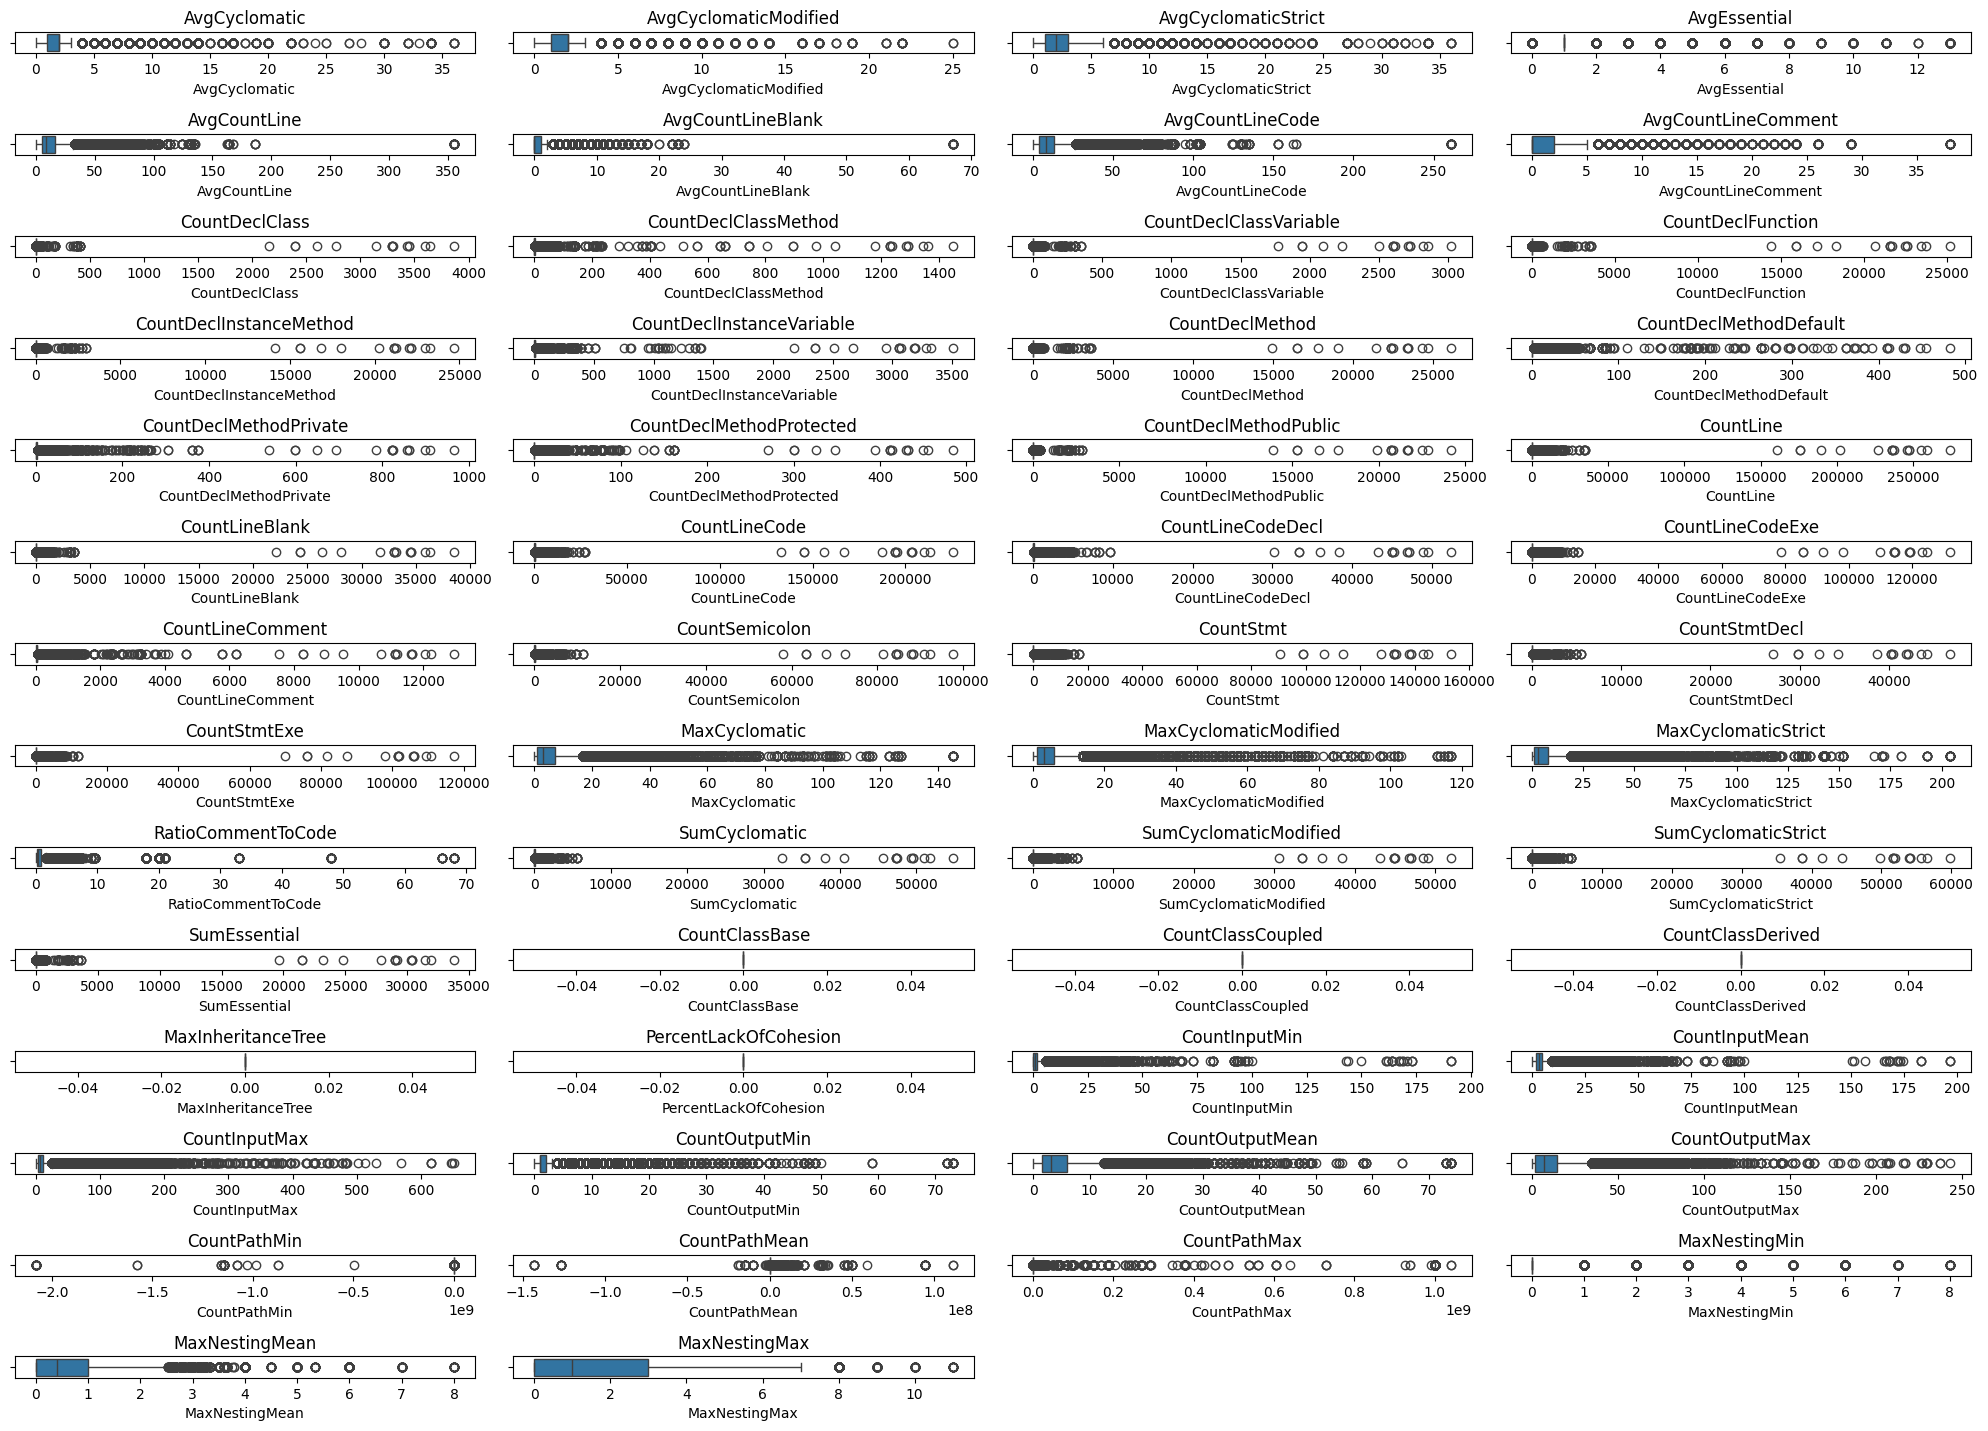

In [8]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(15, 4, i)
    sns.boxplot(x=data[feature])
    plt.title(f'{feature}')
plt.tight_layout()
plt.show()

In [9]:
X = data.drop('Bug', axis=1)
y = data['Bug']

X_no_outliers = data_no_outliers.drop('Bug', axis=1)
y_no_outliers = data_no_outliers['Bug']


print("Class distribution for data with outliers :")
print(y.value_counts())
print("Class distribution for data without outliers :")
print(y_no_outliers.value_counts())


Class distribution for data with outliers :
Bug
0    144393
1      2947
Name: count, dtype: int64
Class distribution for data without outliers :
Bug
0    66723
1      531
Name: count, dtype: int64


Considering the above data, we can observe that the vast majority of the files containning bugs do also contain outliers. Hence, they will not be removed

## 2. Data Partitionning and  Correlation Analysis
Here, we want to remove correlated features in ou trainning set and to identify and remove highly correlated features before we'll let scikit learn's train_test_split to automatically split and maintain the distribution of classes for the trainning

In [10]:
def drop_highly_correlated_features(X, threshold=0.9):

    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    X_reduced = X.drop(columns=to_drop)
    
    return X_reduced, to_drop

X, dropped_features = drop_highly_correlated_features(X, threshold=0.85)

print(f"Dropped {len(dropped_features)} features due to high correlation:")
print(dropped_features)


Dropped 26 features due to high correlation:
['AvgCyclomaticModified', 'AvgCyclomaticStrict', 'AvgCountLineCode', 'CountDeclClassVariable', 'CountDeclFunction', 'CountDeclInstanceMethod', 'CountDeclInstanceVariable', 'CountDeclMethod', 'CountDeclMethodProtected', 'CountDeclMethodPublic', 'CountLine', 'CountLineBlank', 'CountLineCode', 'CountLineCodeDecl', 'CountLineCodeExe', 'CountLineComment', 'CountSemicolon', 'CountStmt', 'CountStmtDecl', 'CountStmtExe', 'MaxCyclomaticModified', 'MaxCyclomaticStrict', 'SumCyclomatic', 'SumCyclomaticModified', 'SumCyclomaticStrict', 'SumEssential']


Given the class imbalance, we'll use stratified splitting to maintain the class distribution across all set

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,            
    random_state=42       
)

## 3. Over-and-Undersampling
Since our data is heavily imbalanced, we'll need to use an algorithm to oversample our minority class while undersampling the majority class. SMOTE generates synthetic samples for minority classes based on the feature space of the original dataset. It uses a weighted distribution to prioritize minority class examples that are harder to learn.

In [12]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

smote_data = pd.concat([pd.DataFrame(X_smote), pd.Series(y_smote)], axis=1)

majority_class = smote_data[smote_data.iloc[:, -1] == 0]
minority_class = smote_data[smote_data.iloc[:, -1] == 1]

majority_downsampled = resample(majority_class,
                                replace=False, 
                                n_samples=len(minority_class),  
                                random_state=42)

balanced_data = pd.concat([majority_downsampled, minority_class])

X_train_resampled = balanced_data.iloc[:, :-1]
y_train_resampled = balanced_data.iloc[:, -1]

print(Counter(y_train_resampled))

C:\Users\14387\anaconda3\envs\MasterSoftwareEngineering\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\14387\anaconda3\envs\MasterSoftwareEngineering\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Counter({0: 108295, 1: 108295})


## 4. Model Trainning
As per the specification of the project, we want to compare logistic regression and and random forest. We'll use recursive feature elimination (*RFECV*) and custom class weights. This will allow us to better identify the most and least important variables in our dataset, improve performance of our models while allowing us to still fairly compare our two models.

In [13]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train_resampled
)

class_weight_custom = {0: class_weights[0], 1: class_weights[1]}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

thresholds = np.arange(0.500000, 0.999999, 0.00001).tolist()


### 4.1. Logistic Regression
We'll begin by setting up our logistic regression and then we'll proceed to train the model on our data

In [14]:
log_reg = LogisticRegression(
    solver='sag',         
    penalty='l2',          
    max_iter=1000000,         
    n_jobs=-1,             
    random_state=42,
    tol=1e-6,
    class_weight=class_weight_custom    
)

log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('Logistic_Regression', log_reg)
])

In [15]:
log_reg_pipeline.fit(X_train_resampled, y_train_resampled)

y_pred_proba_log_reg = log_reg_pipeline.predict_proba(X_test)[:, 1]

best_threshold = 0.5
best_precision = 0

for threshold in thresholds:
    y_pred_custom = (y_pred_proba_log_reg >= threshold).astype(int)
    precision = precision_score(y_test, y_pred_custom)

    if precision > best_precision: 
        best_threshold = threshold
        best_precision = precision  

y_pred_log_reg = (y_pred_proba_log_reg >= best_threshold).astype(int)

print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

print(f'Best Threshold: {best_threshold:.2f}')
roc_auc_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg)
print(f'AUC Score - Logistic Regression: {roc_auc_log_reg:.2f}')

fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_proba_log_reg)


Final Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     36098
           1       0.38      0.03      0.05       737

    accuracy                           0.98     36835
   macro avg       0.68      0.51      0.52     36835
weighted avg       0.97      0.98      0.97     36835

Best Threshold: 0.99
AUC Score - Logistic Regression: 0.75


### 4.2. Random Forest
Exactly as above, we'll set up our random forest model trainning before testing it

In [16]:
random_forest = RandomForestClassifier(
    n_estimators=10000,
    max_depth=100,
    min_samples_split=5,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
    class_weight=class_weight_custom
)
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('random forest', random_forest)
])

In [17]:
rf_pipeline.fit(X_train_resampled, y_train_resampled)

y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

best_threshold = 0.5
best_precision = 0

for threshold in thresholds:
    y_pred_custom = (y_pred_proba_rf >= threshold).astype(int)
    precision = precision_score(y_test, y_pred_custom)
    print(f"Threshold: {threshold:.2f}, Precision: {precision:.4f}")

    if precision > best_precision: 
        best_threshold = threshold
        best_precision = precision  

y_pred_rf = (y_pred_proba_log_reg >= best_threshold).astype(int)

print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_rf))

print(f'Best Threshold: {best_threshold}')
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f'AUC Score - Random Forest: {roc_auc_rf:.4f}')


fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)


MemoryError: Unable to allocate 1.65 MiB for an array with shape (216590,) and data type int64

### 4.3. Model Comparison

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f'Regression Logistique (AUC = {roc_auc_log_reg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

## 5. Interpretability of both Models 
In this section, we'll simply graph nomograms for each fo the models trainned above before we'll identify the vaiables of importance in each of the two models. 

### 5.1. Logistic Regression and Random Forest Nomograms
Here are the nomograms for both the models trained

In [ ]:
feature_names = X_train_resampled.columns if hasattr(X_train_resampled, 'columns') else [f"Feature {i}" for i in range(X_train_resampled.shape[1])]

log_reg_coefs = log_reg_pipeline.named_steps['Logistic_Regression'].coef_.flatten()
rf_importances = rf_pipeline.named_steps['random forest'].feature_importances_

log_reg_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': log_reg_coefs
}).sort_values(by='Coefficient', key=abs, ascending=False)

rf_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 15))
plt.barh(log_reg_df['Feature'], log_reg_df['Coefficient'], color='skyblue')
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Logistic Regression Nomogram')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 15))
plt.barh(rf_df['Feature'], rf_df['Importance'], color='lightgreen')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.show()


### 5.2. Top Features
In this simple graph, we can visualize the relative importance to the model for their top five features

In [ ]:
log_reg_coefs = abs(log_reg_pipeline.named_steps['Logistic_Regression'].coef_.flatten())
log_reg_df = pd.DataFrame({
    'Feature': feature_names,
    'Logistic Regression Importance': log_reg_coefs
})

log_reg_df['Logistic Regression Importance'] = 100 * log_reg_df['Logistic Regression Importance'] / log_reg_df['Logistic Regression Importance'].sum()

rf_importances = rf_pipeline.named_steps['random forest'].feature_importances_
rf_df = pd.DataFrame({
    'Feature': feature_names,
    'Random Forest Importance': rf_importances
})

rf_df['Random Forest Importance'] = 100 * rf_df['Random Forest Importance'] / rf_df['Random Forest Importance'].sum()

combined_df = log_reg_df.merge(rf_df, on='Feature')
combined_df['Combined Importance'] = combined_df[['Logistic Regression Importance', 'Random Forest Importance']].max(axis=1)
combined_df = combined_df.sort_values(by='Combined Importance', ascending=False).head(10)

plt.figure(figsize=(19, 8))
bar_width = 0.4
x_indices = range(len(combined_df))

plt.barh(
    [x + bar_width for x in x_indices],
    combined_df['Logistic Regression Importance'],
    height=bar_width,
    label='Logistic Regression (Relative)',
    color='skyblue'
)
plt.barh(
    x_indices,
    combined_df['Random Forest Importance'],
    height=bar_width,
    label='Random Forest (Relative)',
    color='lightgreen'
)

plt.yticks([x + bar_width / 2 for x in x_indices], combined_df['Feature'])
plt.xlabel('Relative Importance (%)')
plt.title('Top Features - Logistic Regression vs. Random Forest (Relative Importance, %)')
plt.legend()
plt.gca().invert_yaxis()
plt.show()


## 6. Minor Version Comparison
Here we want to compare the major metrics for on different versions of Apache Hive. Hence, we'll train, using random forest, (the better model according to the above data), a model for each version of the project.

In [ ]:
input_files = glob.glob(os.path.join(project_repo, 'UND_hive_updated_data', '*.csv'))

minor_version_dfs = {}

for file in input_files:
    df = pd.read_csv(file)
    version = extract_version(file) 

    if re.match(r'^\d+\.\d+\.0$', str(version)):
        df.insert(loc=2, column='Version', value=version)
        
        if version not in minor_version_dfs:
            minor_version_dfs[version] = []

        minor_version_dfs[version].append(df)

In [ ]:
for version, df_list in minor_version_dfs.items():
    
    for idx, data in enumerate(df_list):
        selected_data = data.iloc[:, [
            0, 7, 8, 9, 11, 3, 4, 5, 6, 20, 21, 22, 27, 28, 29, 33, 36, 38, 39,
            40, 42, 43, 44, 45, 46, 47, 53, 54, 55, 57, 64, 65, 66, 75, 76,
            77, 78, 80, 16, 17, 19, 70, 73, 82, 83, 84, 85, 86, 87, 88, 89,
            90, 91, 92, 93
        ]]

        selected_data.dropna(inplace=True)
        selected_data = selected_data.reset_index(drop=True)

        X = selected_data.drop('Bug', axis=1)
        y = selected_data['Bug']

        if len(y.value_counts()) != 2:
            continue

        X, dropped_features = drop_highly_correlated_features(X, threshold=0.85)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, stratify=y, random_state=42
        )

        X_smote, y_smote = smote.fit_resample(X_train, y_train)
        smote_data = pd.concat([pd.DataFrame(X_smote), pd.Series(y_smote)], axis=1)

        majority_class = smote_data[smote_data.iloc[:, -1] == 0]
        minority_class = smote_data[smote_data.iloc[:, -1] == 1]

        majority_downsampled = resample(
            majority_class,
            replace=False,
            n_samples=len(minority_class),
            random_state=42
        )

        balanced_data = pd.concat([majority_downsampled, minority_class])

        X_train_resampled = balanced_data.iloc[:, :-1]
        y_train_resampled = balanced_data.iloc[:, -1]

        rf_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('random forest', RandomForestClassifier(random_state=42))
        ])

        rf_pipeline.fit(X_train_resampled, y_train_resampled)

        y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
        y_pred_rf = (y_pred_proba_rf >= best_threshold).astype(int)

        print("\nFinal Classification Report:")
        print(classification_report(y_test, y_pred_rf))

        print(f'Best Threshold: {best_threshold}')
        roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
        print(f'AUC Score - Random Forest: {roc_auc_rf:.4f}\n\n\n\n\n\n\n')


## 7. Major Version Interpretability
Finally, in this section, we'll regroup our data by major version to observe what the most impactful features were for each version and how they compare to the other major versions

In [ ]:
input_files = glob.glob(os.path.join(project_repo, 'UND_hive_updated_data', '*.csv'))

version_dfs = {}

for file in input_files:
    df = pd.read_csv(file)
    version = extract_version(file)  
    
    if re.match(r'^\d+\.\d+\.\d+$', str(version)):
        df.insert(loc=2, column='Version', value=version)
        
        if version not in version_dfs:
            version_dfs[version] = []
    
        version_dfs[version].append(df)
    else:
        print(f"File '{file}' has an invalid version format: '{version}'")

In [ ]:
major_version_dfs = defaultdict(list)

for version, df_list in version_dfs.items():
    version_str = str(version)
    
    match = re.match(r'^(\d+)\.\d+\.\d+$', version_str)
    if match:
        major_num = match.group(1)
        major_version = f"{major_num}.0.0"
        major_version_dfs[major_version].extend(df_list)
    else:
        print(f"Version '{version_str}' does not match the expected pattern.")


In [ ]:
for major_version, df_list in major_version_dfs.items():
    if df_list: 
        concatenated_df = pd.concat(df_list, ignore_index=True)
        major_version_dfs[major_version] = concatenated_df
    else:
        major_version_dfs[major_version] = pd.DataFrame()

### 7.1 - Nomograms

In [ ]:
for major_version, concatenated_df in major_version_dfs.items():
    print(f"\nProcessing Version: {major_version}")

    if concatenated_df.empty:
        print(f"No data available for major version {major_version}. Skipping.")
        continue

    selected_columns = [
        0, 7, 8, 9, 11, 3, 4, 5, 6, 20, 21, 22, 27, 28, 29, 33, 36, 38, 39,
        40, 42, 43, 44, 45, 46, 47, 53, 54, 55, 57, 64, 65, 66, 75, 76,
        77, 78, 80, 16, 17, 19, 70, 73, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93
    ]
    
    max_col = concatenated_df.shape[1] - 1
    selected_columns = [col for col in selected_columns if col <= max_col]
    
    selected_data = concatenated_df.iloc[:, selected_columns].copy()

    selected_data.dropna(inplace=True)
    selected_data.reset_index(drop=True, inplace=True)

    if 'Bug' not in selected_data.columns:
        print(f"'Bug' column not found in data for version {major_version}. Skipping.")
        continue

    X = selected_data.drop('Bug', axis=1)
    y = selected_data['Bug']

    if len(y.value_counts()) != 2:
        print(f"Skipping Version {major_version} - Does not have binary classes")
        continue

    X, dropped_features = drop_highly_correlated_features(X, threshold=0.85)
    if dropped_features:
        print(f"Dropped features due to high correlation: {dropped_features}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, random_state=42
    )

    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    smote_data = pd.concat([pd.DataFrame(X_smote, columns=X_train.columns), 
                            pd.Series(y_smote, name='Bug')], axis=1)

    majority_class = smote_data[smote_data['Bug'] == 0]
    minority_class = smote_data[smote_data['Bug'] == 1]

    majority_downsampled = resample(
        majority_class,
        replace=False,
        n_samples=len(minority_class),
        random_state=42
    )

    balanced_data = pd.concat([majority_downsampled, minority_class])

    X_train_resampled = balanced_data.drop('Bug', axis=1)
    y_train_resampled = balanced_data['Bug']

    print(f"Balanced target class distribution for Version {major_version}:")
    print(Counter(y_train_resampled))

    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('random_forest', RandomForestClassifier(random_state=42))
    ])

    rf_pipeline.fit(X_train_resampled, y_train_resampled)

    y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
    y_pred_rf = (y_pred_proba_rf >= best_threshold).astype(int)

    feature_names = X_train_resampled.columns.tolist()

    rf_importances = rf_pipeline.named_steps['random_forest'].feature_importances_
    
    rf_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': rf_importances
    }).sort_values(by='Importance', ascending=False)
    
    colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(len(rf_df))]
    
    plt.figure(figsize=(10, 15))
    plt.barh(rf_df['Feature'], rf_df['Importance'], color=colors)
    plt.title(f'Random Forest Feature Importance (Version: {major_version})')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.gca().invert_yaxis()  
    plt.show()

    # Classification report and metrics
    print("\nFinal Classification Report:")
    print(classification_report(y_test, y_pred_rf))

    print(f'Best Threshold: {best_threshold}')
    roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
    print(f'AUC Score - Random Forest: {roc_auc_rf:.4f}')

    print("\nPrediction Distribution:")
    print(pd.Series(y_pred_rf).value_counts())
    print("\nDataFrame processing completed successfully")
    print("\n" * 10) 